In [33]:
import tensorflow
import keras
import os

import pandas as pd
import numpy as np
import soundfile as sf
import model_cfg

In [2]:
data_path = os.path.join(model_cfg.AUDIOSET_PATH, "singing", "15eEzvCHuKw_30000_40000.flac")
data_path

'/Users/dcleres/sound_classification_app/SoundClassification/../Data/AudioSet/audio/singing/15eEzvCHuKw_30000_40000.flac'

In [3]:
data, samplerate = sf.read(data_path)

In [4]:
data.shape

(480000, 2)

In [5]:
t_start = 9600
samples_per_n_seconds = 10
data[t_start:t_start + samples_per_n_seconds]

array([[0.10925293, 0.10925293],
       [0.12713623, 0.12713623],
       [0.16027832, 0.16027832],
       [0.16833496, 0.16833496],
       [0.15176392, 0.15176392],
       [0.15270996, 0.15270996],
       [0.17556763, 0.17556763],
       [0.19284058, 0.19284058],
       [0.20056152, 0.20056152],
       [0.20831299, 0.20831299]])

In [6]:
def crop_n_second_pieces(data, samplerate):
    """
    The sample rate is in hertz. It was decided to keep only the 6 seconds in the middle of the audio recording.
    """
    duration = 2 # duration in seconds
    samples_per_n_seconds = samplerate * duration
    X_samples = np.array([]).reshape(-1, samples_per_n_seconds, 2)

    
    for start in range(9600, 38400, 9600):
        X_samples = np.concatenate((X_samples, data[t_start:t_start + samples_per_n_seconds].reshape(1, samples_per_n_seconds, 2)), axis = 0)
    
    return X_samples
    

In [7]:
speech_data_df = pd.read_csv(os.path.join(model_cfg.AUDIOSET_PATH, "speech_data_sampled.csv"))
silence_data_df = pd.read_csv(os.path.join(model_cfg.AUDIOSET_PATH, "silence_data_sampled.csv"))
singing_data_df = pd.read_csv(os.path.join(model_cfg.AUDIOSET_PATH, "singing_data_sampled.csv"))

In [8]:
def build_train_array(label, max_samples = 200):

    X = np.array([]).reshape(-1, 96000, 2) # 96 000 is 2 seconds at sample rate 48 000

    for filename in os.listdir(os.path.join(model_cfg.AUDIOSET_PATH, label)):
        data_path = os.path.join(model_cfg.AUDIOSET_PATH, label, filename)
        data, samplerate = sf.read(data_path)

        # Crop 2 seconds pieces of the audio to train on 2 second files
        X_samples = crop_n_second_pieces(data, samplerate)

        X = np.concatenate((X, X_samples), axis = 0)
        
        if X.shape[0]  > max_samples:
            break
        
    return X

In [9]:
X_singing = build_train_array("singing", max_samples = 200)
X_silence = build_train_array("silence", max_samples = 200)
X_speech = build_train_array("speech", max_samples = 200)

## Write one of the coumns to check if things are working 

In [13]:
sf.write("speech_sample.wav", X_speech[102], samplerate)

data, sample_rate = sf.read("speech_sample.wav")
data.shape

(96000, 2)

## Save all 2 seconds data files to wav files

In [19]:
import librosa

In [29]:
data, sample_rate = sf.read("speech_sample.wav")
data[:, 0]

array([-0.0244751 , -0.0345459 , -0.04013062, ..., -0.30883789,
       -0.30752563, -0.29031372])

In [30]:
wave, sr = librosa.load("speech_sample.wav", mono=True, sr=None)
wave
sr

48000

In [85]:
def convert_data_to_mfcc(wave, sampling_rate, max_pad_len=256,padding=True):
    mfcc = librosa.feature.mfcc(wave, sr=sampling_rate)
    pad_width = max_pad_len - mfcc.shape[1]
    pad_height = max_pad_len - mfcc.shape[0]
    mfcc = np.pad(mfcc, pad_width=((0, pad_height), (0, pad_width)), mode='constant')
    return mfcc

In [86]:
import matplotlib.pyplot as plt

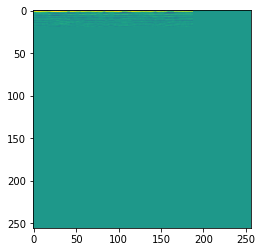

In [87]:
data = convert_data_to_mfcc(np.asfortranarray(X_speech[5, :, 0]), sr)
plt.imshow(data)

In [88]:
data.shape

(256, 256)

In [72]:
X_speech[103, :, 0].shape

(96000,)

## Split the data into training, validation and testing set

In [17]:
# put everything into a pd.dataframe to shuffle things etc.
speech_data_df = pd.DataFrame(data = {"X": X_speech})

ValueError: If using all scalar values, you must pass an index